In [1]:
from sklearn.cluster import FeatureAgglomeration
import numpy as np
import pandas as pd
import geopandas as gpd
import multiprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import glob

In [6]:

def open_df():
    
    rgb_df = pd.read_csv('last_day_identifications.csv')
    flir_df = pd.read_csv(current_file)
    
    # rgb_df = rgb_df.query('plot == "MAC_Field_Scanner_Season_10_Range_10_Column_17"')
    # flir_df = flir_df.query('plot == "MAC_Field_Scanner_Season_10_Range_10_Column_17"')
    return rgb_df, flir_df

def move_flir_to_rgb(flir_identifications):
    flir_translation_constant = (1.0272989925397269e-07*3, 1.5250405240863074e-06)
    try:
        flir_identifications = flir_identifications.reset_index()
    except:
        pass
    # try apply
    for index, row in flir_identifications.iterrows():
        flir_identifications.loc[index, 'lat'] = flir_identifications.loc[index,'lat'] + flir_translation_constant[1]
        flir_identifications.loc[index, 'lon'] = flir_identifications.loc[index, 'lon'] - flir_translation_constant[0]
    return flir_identifications


def find_shared_plots(rgb_df, flir_df):
    
    rgb_df, flir_df = open_df()
    rgb_plots = rgb_df['plot'].unique()
    flir_plots = flir_df['plot'].unique()
    
    return list(set(rgb_plots) & set(flir_plots))


def cluster_plot(plot):
    
    rgb_df, flir_df = open_df()
    # print('len before', len(rgb_df))
    rgb_df = rgb_df.query(f'plot == "{plot}"')
    # print('len after', len(rgb_df))

    flir_df = flir_df.query(f'plot == "{plot}"')

    flir_df = move_flir_to_rgb(flir_df)
    genotype = flir_df['genotype']

    rgb_lat_lon = rgb_df[["lat", "lon"]]
    flir_lat_lon = flir_df[["lat", "lon"]]

    df = pd.concat([rgb_lat_lon, flir_lat_lon])
    #arr = np.array([df['lat'], df['lon']])
    arr = np.array([df['lat'], df['lon']])
    
    max_clusters = np.max([len(rgb_lat_lon), len(flir_lat_lon)])


    # Pretty Good
    # agglo = FeatureAgglomeration(n_clusters=None, compute_full_tree = True, distance_threshold = 0.000003, linkage='ward')

    # Final
    agglo = FeatureAgglomeration(n_clusters=None, compute_full_tree = True, distance_threshold = 0.0000012, linkage='ward')


    # Testing

    # agglo = FeatureAgglomeration(n_clusters=None, affinity='euclidean', memory=None, connectivity=None, compute_full_tree='auto', linkage='average', distance_threshold= 0.000003)

    # agglo = FeatureAgglomeration(n_clusters=max_clusters, linkage='complete', affinity='cosine')

    res = agglo.fit(arr)

    labels = res.labels_
    plot = np.array(genotype)
    #print(np.jo(labels, plot))
    df['labels'] = labels
    df['genotype'] = genotype

    #Testing
    global rgb_df2
    rgb_df2 = rgb_df

    rgb_df2['labels'] = 9999

    flir_df2 = flir_df
    flir_df2['labels'] = 9999
    flir_df2['plant_name'] = 'NaN'
    

    # print('number of rgb points to cluster: ',len(rgb_df2))
    # print('number of flir points to cluster: ', len(flir_df2))

    for index, row in rgb_df2.iterrows():
        rgb_df2.loc[[index],['labels'] ]  = df.labels[(df['lat'] == row['lat']) & (df['lon'] == row['lon'])]


    

    # Clearing out double rgb labels
    label_list = rgb_df2['labels'].unique()
    
    for i in label_list:
        
        if len(rgb_df2[rgb_df2['labels'] == i]) > 1:
            one_label = rgb_df2[rgb_df2['labels'] == i]
            min_val = one_label['bounding_area_m2'].min()
            rgb_df2 = rgb_df2[rgb_df2['bounding_area_m2'] != min_val]


    # print(rgb_df2)

    # print(label_list)

    for index, row in flir_df2.iterrows():
        flir_df2.loc[[index],['labels'] ]  = df.labels[(df['lat'] == row['lat']) & (df['lon'] == row['lon'])]

    label_dict = pd.Series(rgb_df2.labels.values,index=rgb_df2.plant_name).to_dict()

    my_dict2 = {y:x for x,y in label_dict.items()}

    rgb_df2.to_csv('rgb_test.csv')
    # print(label_dict)
    # print(my_dict2)

    for index, row in flir_df2.iterrows():

        try:
            # print('before',flir_df2.loc[[index],['plant_name']] )
            flir_df2.loc[[index],['plant_name']] = my_dict2[row['labels']]
            # print('after',flir_df2.loc[[index],['plant_name']] )

            # print('labeled') 

        except:
            flir_df2.loc[[index],['plant_name']] = 'NaN'
            # print(row.labels)

    # Clearing out double day identifications for flir
    
    # Clearing out double rgb labels
    plant_list = flir_df2['plant_name'].unique()
    date_list = flir_df2['date'].unique()
    
    # for i in plant_list:

    #     one_plant_df = flir_df2[flir_df2['plant_name'] == i]

    #     for x in date_list:
        
    #         if len(one_plant_df[one_plant_df['date'] == x]) > 1:
    #             one_plant = one_plant_df[one_plant_df['labels'] == i]
    #             min_val = one_plant['bounding_area_m2'].min()
    #             flir_df2 = flir_df2[(flir_df2['bounding_area_m2'] != min_val) & (flir_df2['plant_name'] != i)]
    
    return flir_df2

# def name_flir(flir_df, rgb_df):

#     rgb_df['labels'] = labels
#     label_dict = pd.Series(rgb_df.labels.values,index=rgb_df.plant_name).to_dict()

#     for index, row in flir_df.iterrows():
#         flir_df['plant_name'] = label_dict[row['labels']] 

#     return rgb_df

In [3]:
all_flir_csv = glob.glob(r"/home/travis/data/FLIR_indv_plant_temp_S10/*csv")

major_df = pd.DataFrame()

for current_file in all_flir_csv:
        
    rgb_df, flir_df = open_df()
    plot_list = find_shared_plots(rgb_df, flir_df)
    # plot_list = ['MAC_Field_Scanner_Season_10_Range_30_Column_8']
    # plot_list = ['MAC_Field_Scanner_Season_10_Range_32_Column_18']


   

    with multiprocessing.Pool(multiprocessing.cpu_count()-1) as p:
        df = p.map(cluster_plot, plot_list)
        major_df = major_df.append(df)
        #cluster_plot(rgb_df, flir_df, plot)

<AxesSubplot:xlabel='lon', ylabel='lat'>

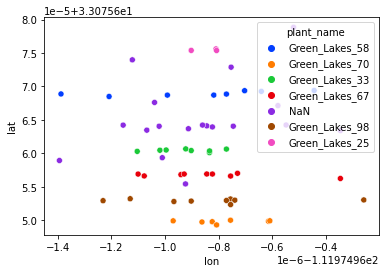

In [4]:
k = major_df["plant_name"].nunique()
fig, ax = plt.subplots()
sns.scatterplot(x="lon", y="lat", data=major_df, 
                palette=sns.color_palette("bright",k),
                hue='plant_name', legend= 'brief', ax=ax)
# ax.scatter(th_centroids[:,0], th_centroids[:,1], s=50, c='black', 
#            marker="x")

In [5]:
major_df.to_csv('flir_agg_feature_clustering_all_days.csv')

# major_df.to_csv('methods_testing_2_21.csv')